# Axis 1: Somme study about 

In [97]:
import sys
import pickle

from pathlib import Path
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


## Initialisations

In [98]:
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



Root folder detected at: /Users/43rt1k/Documents/EPFL/_MASTER/ADA/ADAcore42


In [99]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(root / DATA_PREPARATION_PY_PATH) #If works: ...../ADAcore42/src/data/DataPreparation.py

/Users/43rt1k/Documents/EPFL/_MASTER/ADA/ADAcore42/src/data/DataPreparation.py


In [100]:
# %run {root / DATA_PREPARATION_PY_PATH}

In [101]:
# Pickle datapreprocessed file loading
with open(root / STORED_DATAPREP_PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Objects extraction
dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']
dataA[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,22.19
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,18.99
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,13.87
3,Anyone who steps on me is out!,1.583333,0.259905,12,8,1,3,11.62
4,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,11.60
...,...,...,...,...,...,...,...,...
3900,My relaxation app still has a few bugs to work...,1.000000,0.095346,11,11,0,0,-3.19
3901,Make sure you don't step on the lines,1.000000,0.095346,11,11,0,0,-3.19
3902,Ohhhh my goshhh! Stop trampling me its just a ...,1.000000,0.095346,11,11,0,0,-3.19
3903,Sometimes you just have to stop and get to kno...,1.000000,0.087039,12,12,0,0,-3.92


# 1. How does the votes nb influence the caption rating?

In [102]:
vote_cols = ['not_funny', 'somewhat_funny', 'funny', 'votes', 'funny_score']
funny_cols = ['not_funny', 'somewhat_funny', 'funny']
dataA[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,22.19
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,18.99
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,13.87
3,Anyone who steps on me is out!,1.583333,0.259905,12,8,1,3,11.62
4,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,11.60
...,...,...,...,...,...,...,...,...
3900,My relaxation app still has a few bugs to work...,1.000000,0.095346,11,11,0,0,-3.19
3901,Make sure you don't step on the lines,1.000000,0.095346,11,11,0,0,-3.19
3902,Ohhhh my goshhh! Stop trampling me its just a ...,1.000000,0.095346,11,11,0,0,-3.19
3903,Sometimes you just have to stop and get to kno...,1.000000,0.087039,12,12,0,0,-3.92


As vote number reference lets take the winning caption with the smallest votes number

In [103]:
minnestVotes = 1000000

for idx, df in enumerate(dataA):
    best3 = df.head(1)
    minVotes = best3['votes'].min()

    if minVotes < minnestVotes: minnestVotes = minVotes

print("The smallest votes number of the winning caption: ", minnestVotes)

The smallest votes number of the winning caption:  11


### 1. How does the populyrity(number of votes) of a caption correlate with captions rank

In [104]:
#Stick all captions together
dataAm = pd.concat(dataA, ignore_index=True)

dataAm.sort_values(by='funny_score', ascending=False, inplace=True)
dataAm.reset_index(drop=True, inplace=True)
#Keep only vote related cols
dataAmf = dataAm[vote_cols]
#Sort by vote nb
dataAmf.sort_values(by="votes", ascending=True, inplace=True)
dataAmf.reset_index(drop=True, inplace = True)

#Remove captions with less than minnest votes 
dataAmf = dataAmf[dataAmf['votes'] >= minnestVotes]

/var/folders/rm/6cts8xbd71sdxxq6yzvk7vg00000gn/T/ipykernel_4078/387322037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataAmf.sort_values(by="votes", ascending=True, inplace=True)


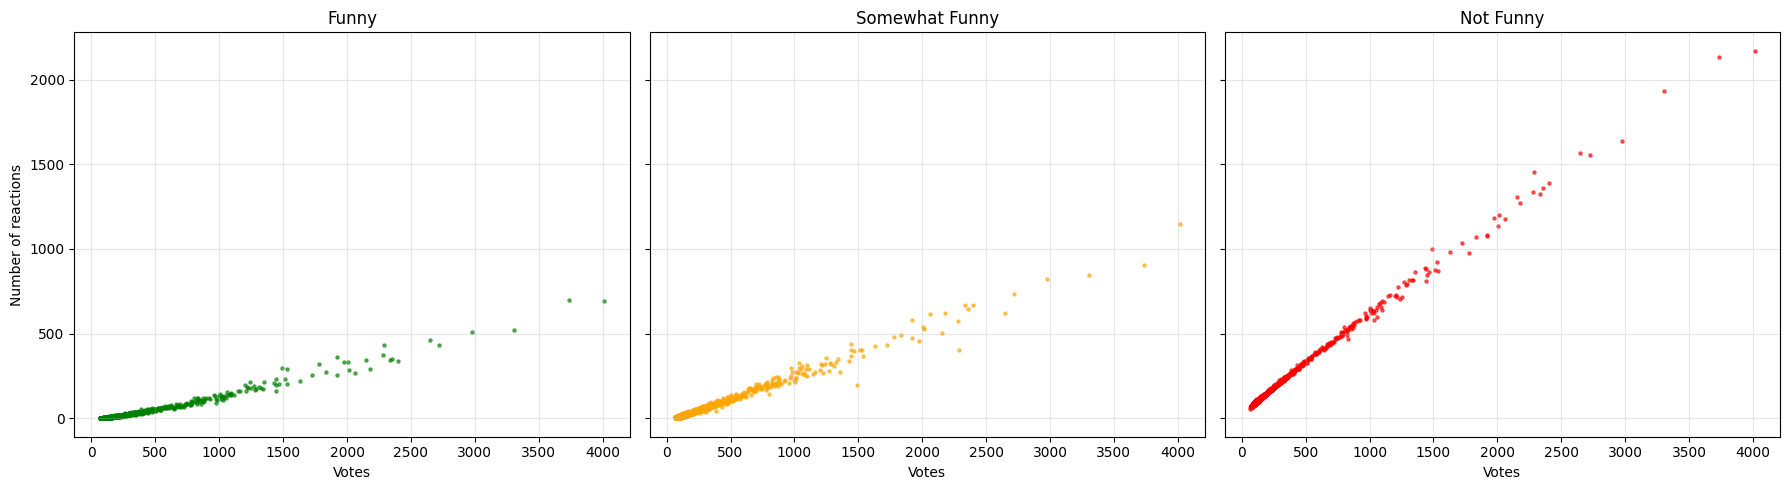

In [105]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

plots = [
    ('funny', 'green'),
    ('somewhat_funny', 'orange'),
    ('not_funny', 'red'),
]

for ax, (col, color) in zip(axes, plots):
    ax.scatter(df['votes'], df[col], s=5, alpha=0.6, color=color)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel("Votes")
    ax.grid(True, alpha=0.3)


axes[0].set_ylabel("Number of reactions")


plt.tight_layout()
plt.show()

From this we can conclude: 
- The evaluation (++, +, -) grows with the vote number, but differently
- The grow is approximatively linear, thus can be approximated

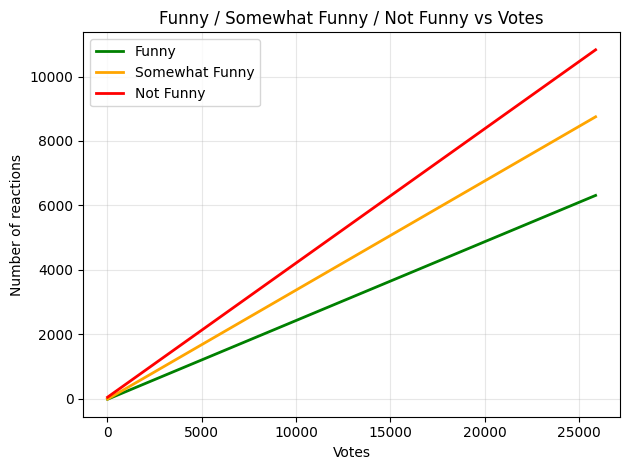

In [106]:
features = [
    ("funny", "green"),
    ("somewhat_funny", "orange"),
    ("not_funny", "red"),
]

X = dataAmf[["votes"]].values
x_line = np.linspace(dataAmf["votes"].min(), dataAmf["votes"].max(), 500).reshape(-1, 1)

for col, color in features:
    y = dataAmf[col].values

    # Fit regression model
    model = LinearRegression()
    model.fit(X, y)
    y_line = model.predict(x_line)

    # Plot only the regression line
    plt.plot(x_line, y_line, color=color, linewidth=2, label=col.replace("_", " ").title())

plt.xlabel("Votes")
plt.ylabel("Number of reactions")
plt.title("Funny / Somewhat Funny / Not Funny vs Votes")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

When i began working on this, i was expecting the opposite result: more the caption is popular, more ++/+ votes it will have. But wins not the best, but the "less worse".
What about the funny score? 


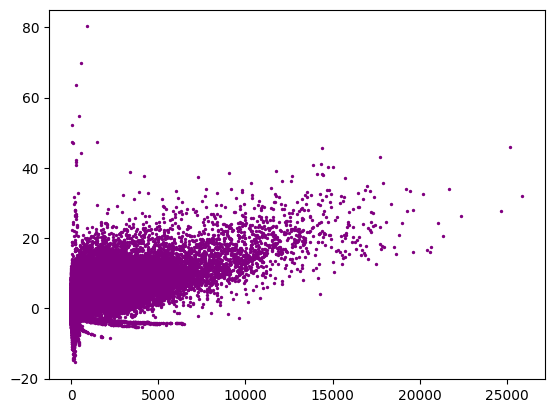

In [107]:
plt.scatter(dataAmf['votes'], dataAmf['funny_score'], s=2, c="purple")
plt.show()

Here we can see, that looking at votes number is impossible to predict if the caption will be the funniest, but we clearly see that more the caption is popular, more is probable that the caption will have a certain minimal rank. I tried with differenc coeffs (default: +2/+1/-1) and the shape of the result didnt change significantly.

In [108]:
X = dataAmf["votes"].values.reshape(-1, 1)
y = dataAmf["funny_score"].values

# Add intercept
X_q = sm.add_constant(X)

# Quantile regression for lower bound (5th percentile)
quantile = 0.05
model = sm.QuantReg(y, X_q)
res = model.fit(q=quantile)

# Create prediction line
x_line = np.linspace(X.min(), X.max(), 500)
X_line = sm.add_constant(x_line)
y_line = res.predict(X_line)

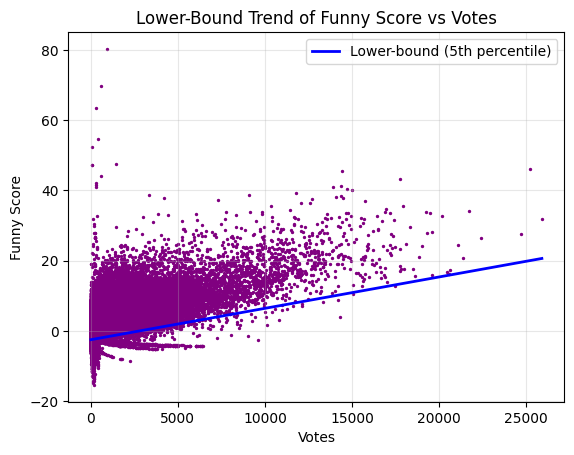

In [109]:
plt.scatter(X, y, s=2, color="purple")
plt.plot(x_line, y_line, color="blue", linewidth=2, label="Lower-bound (5th percentile)")
plt.xlabel("Votes")
plt.ylabel("Funny Score")
plt.title("Lower-Bound Trend of Funny Score vs Votes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

It is obviously not the number of votes itself which gives a good rating to a caption, but the consequence of being a good caption makes it more and more popular (in other words: the funnier is the capton, more popular it will be). On the other hand we see that captions with very negative ratings do not become popular. 

# 2. Estimating the caption funinness?

Is how does the number of words in a caption correlate with the funny score and ++/+/- votes?

In [110]:
dataAm["word_count"] = dataAm["caption"].str.split().str.len()

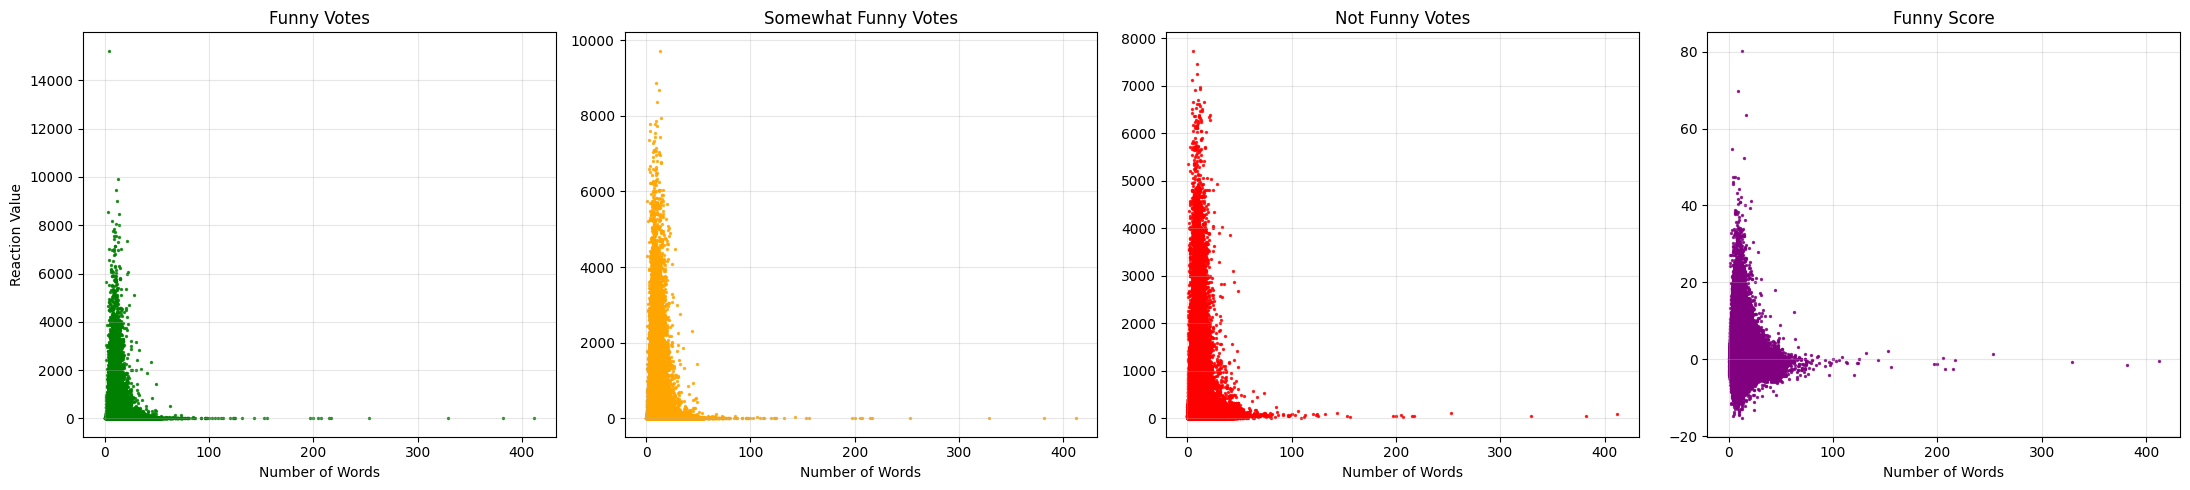

In [111]:
variables = [
    ("funny", "Funny Votes", "green"),
    ("somewhat_funny", "Somewhat Funny Votes", "orange"),
    ("not_funny", "Not Funny Votes", "red"),
    ("funny_score", "Funny Score", "purple"),
]

fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharex=True)

for ax, (col, title, color) in zip(axes, variables):

    ax.scatter(dataAm["word_count"], dataAm[col], s=2, alpha=0.8, color=color)
    ax.set_title(title)
    ax.set_xlabel("Number of Words")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reaction Value")

plt.tight_layout()
plt.show()

From this we can conclude, that there is an optimal number of words to increase the chance of the caption to succeed. Lets find this range!

In [112]:
def get_top_funny_no_outliers(data, quantile=0.80, iqr_coeff=1.15):
    """
    Returns top percentage of captions based on funny_score
    and removes outliers from word_count using IQR method.
    """
    # Threshold for funny score
    threshold = data["funny_score"].quantile(quantile)

    # Top quantile of funny captions
    top_funny = data[data["funny_score"] >= threshold]

    # Quartiles
    Q1 = top_funny["word_count"].quantile(0.25)
    Q3 = top_funny["word_count"].quantile(0.75)
    IQR = Q3 - Q1

    # Outlier boundaries
    lower = Q1 - iqr_coeff * IQR
    upper = Q3 + iqr_coeff * IQR

    # Filter outliers
    filtered = top_funny[(top_funny["word_count"] >= lower) &
                         (top_funny["word_count"] <= upper)]

    stats = {
        "threshold": threshold,
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "lower_bound": lower,
        "upper_bound": upper,
        "initial_count": len(top_funny),
        "filtered_count": len(filtered)
    }

    return filtered, stats

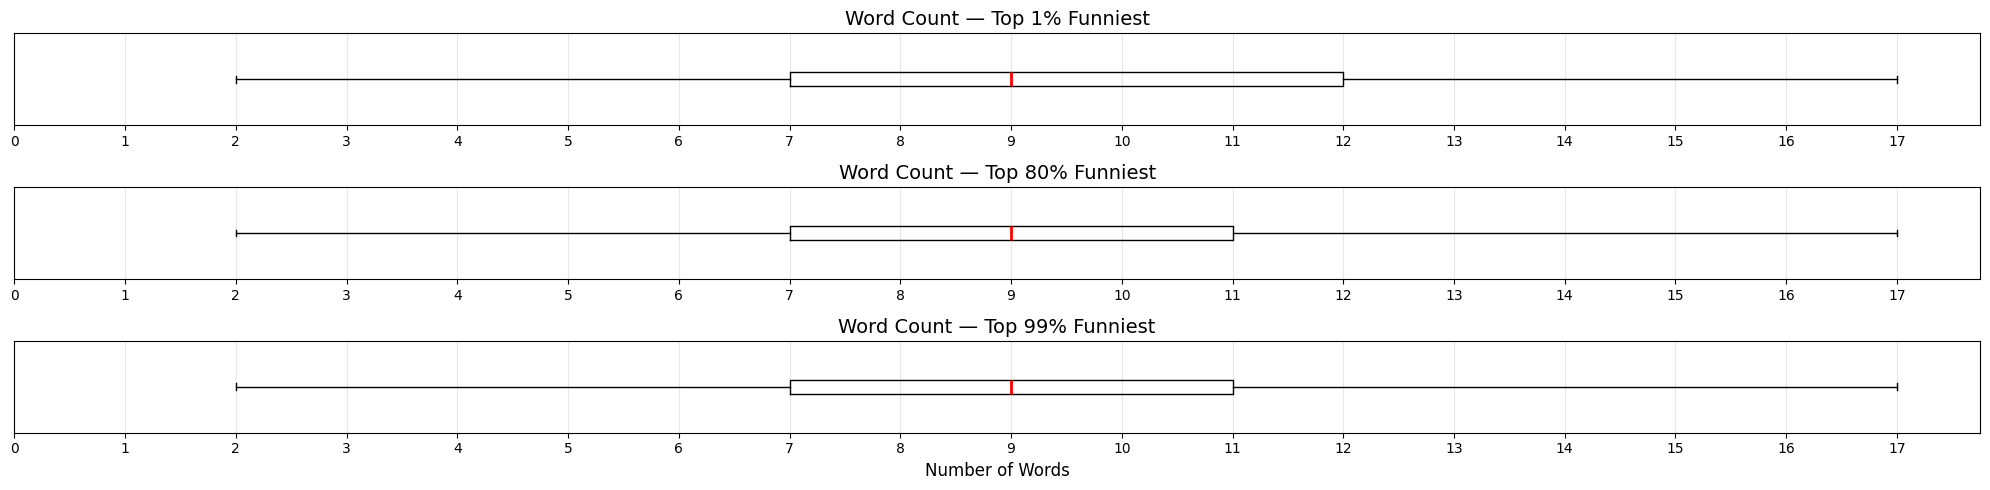

In [113]:
quantiles = [0.01, 0.80, 0.99]
labels = ["Top 1% Funniest", "Top 80% Funniest", "Top 99% Funniest"]

plt.figure(figsize=(20, 5))   # Tall figure for vertical alignment

for i, (q, label) in enumerate(zip(quantiles, labels), start=1):

    # Get filtered dataset
    df_q, _ = get_top_funny_no_outliers(dataAm, quantile=q)

    # Select subplot (3 rows, 1 column)
    plt.subplot(3, 1, i)

    # Boxplot
    plt.boxplot(
        df_q["word_count"],
        vert=False,
        medianprops=dict(color="red", linewidth=2),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        boxprops=dict(color="black")
    )

    # Title
    plt.title(f"Word Count — {label}", fontsize=14)

    # Remove y-axis completely
    plt.yticks([])
    plt.ylabel("")

    # Custom x-axis ticks (dynamic)
    max_wc = df_q["word_count"].max()
    step = max(1, int(max_wc // 15))
    plt.xticks(range(0, max_wc + 1, step))

    # Grid
    plt.grid(axis="x", alpha=0.3)

plt.xlabel("Number of Words", fontsize=12)
plt.tight_layout()
plt.show()

Caption with the best funny score have 9 words...

As the sentence above.

# 3. Looking at funny_score vs caption ending ? | ! | ... | . | x |

In [114]:
def extract_ending(text):
    if not isinstance(text, str): return "~"

    text = text.strip()

    # Check specific endings by priority (longest first)
    if text.endswith("..."):    return "..."
    if text.endswith("?"):      return "?"
    if text.endswith("!"):      return "!"
    if text.endswith("."):      return "."
    return "~"

dataAm["ending"] = dataAm["caption"].apply(extract_ending)

In [115]:
dataAm[['caption', 'ending']].sample(50)

,caption,ending
1723072,I couldn’t have faced a yellow ribbon.,.
9082,"So, I work in risk management...how about you?",?
1478381,Remain distilled and breathe.,.
148966,"I’d join you, but it looks like we’re all out ...",.
132931,It's your turn to swim.,.
1917458,I traded in my car for these guys. Much cheape...,!
1295752,I guess we can watch the Christmas special again.,.
1259170,Claire...is this because my mum in coming for ...,?
721599,Really? It was all over the news when the oven...,.
649944,You called him abominable? I think you hurt hi...,.


Now lets group captions by their ending and look at their distribution according to the ending symbol.

In [116]:
# dataAm_q = dataAm[dataAm['ending'] == '?']
# dataAm_e = dataAm[dataAm['ending'] == '!']
# dataAm_ppp = dataAm[dataAm['ending'] == '...']
# dataAm_p = dataAm[dataAm['ending'] == '.']
# dataAm_t = dataAm[dataAm['ending'] == '~']

dataAm_ending = (dataAm
                .groupby(by='ending')
                .size()
                .reset_index(name='count'))

dataAm_ending = (dataAm_ending
                 .sort_values(by='count', ascending=False)
                .reset_index(drop=True))
dataAm_ending
                


,ending,count
0,.,1301309
1,~,351251
2,?,340577
3,!,243806
4,...,55735


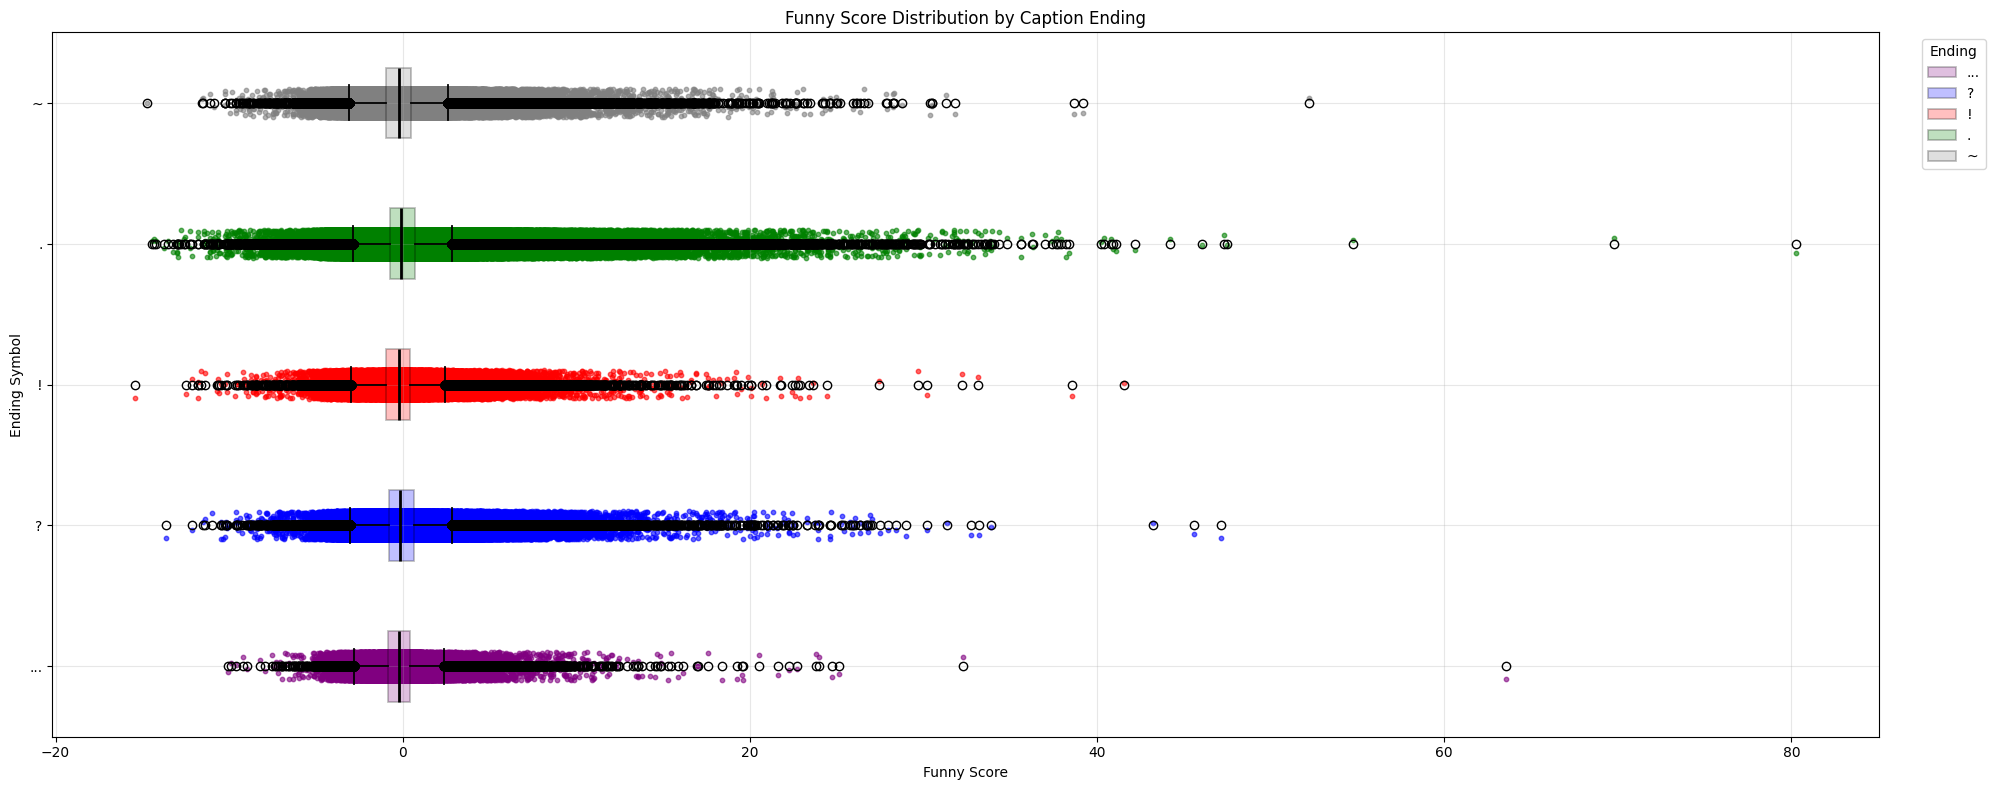

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Unique ending categories in fixed order
endings = ["...", "?", "!", ".", "~"]
colors = ["purple", "blue", "red", "green", "gray"]

plt.figure(figsize=(20, 8))

# Prepare boxplot data (in the same order)
box_data = [dataAm[dataAm["ending"] == end]["funny_score"] for end in endings]

# --- BOXLOT ADDED ---
bp = plt.boxplot(
    box_data,
    vert=False,
    positions=range(len(endings)),
    patch_artist=True,
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.3),
    whiskerprops=dict(linewidth=1.3),
    capprops=dict(linewidth=1.3),
)

# Color each box to match scatter points
for patch, col in zip(bp['boxes'], colors):
    patch.set_facecolor(col)
    patch.set_alpha(0.25)


# --- ORIGINAL SCATTER PLOT ---
for i, (end, col) in enumerate(zip(endings, colors)):
    subset = dataAm[dataAm["ending"] == end]

    # jitter to spread points vertically
    jitter = np.random.uniform(-0.1, 0.1, size=len(subset))

    plt.scatter(
        subset["funny_score"],
        np.full(len(subset), i) + jitter,
        s=10,
        alpha=0.6,
        color=col,
        label=end
    )



# Formatting
plt.yticks(range(len(endings)), endings)
plt.xlabel("Funny Score")
plt.ylabel("Ending Symbol")
plt.title("Funny Score Distribution by Caption Ending")
plt.grid(alpha=0.3)

# Show legend only once
plt.legend(endings, title="Ending", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

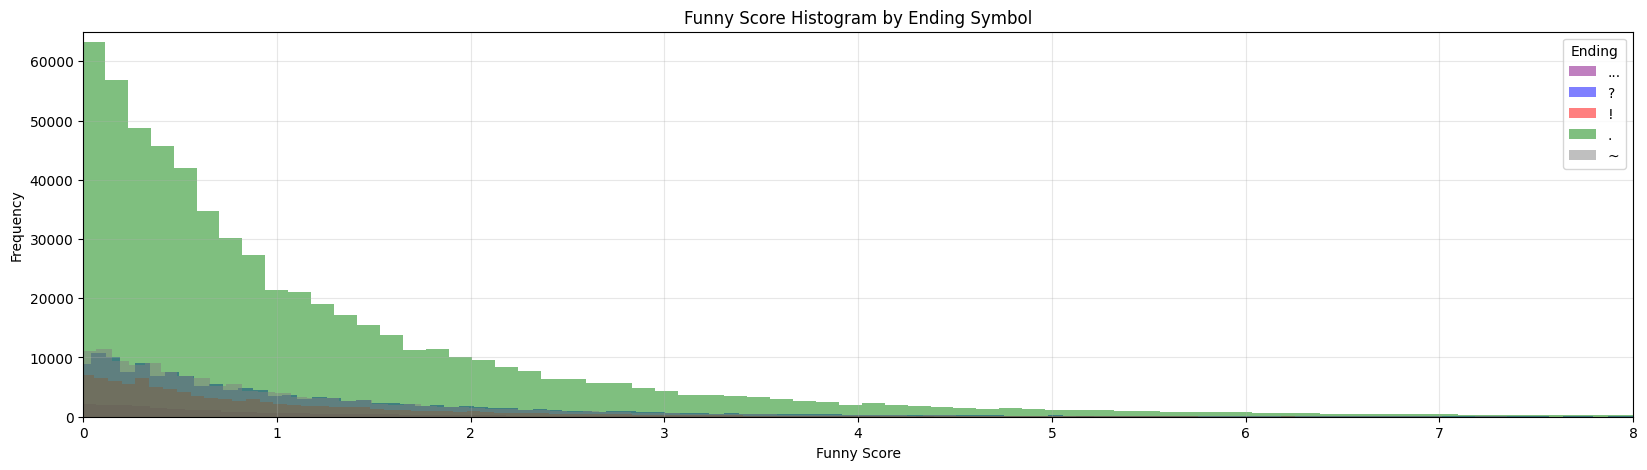

In [152]:
# Unique ending categories in fixed order
endings = ["...", "?", "!", ".", "~"]
colors = ["purple", "blue", "red", "green", "gray"]

plt.figure(figsize=(20, 5))



for end, col in zip(endings, colors):
    subset = dataAm[dataAm["ending"] == end]["funny_score"]

    plt.hist(
        subset,
        bins=800,
        alpha=0.5,
        color=col,
        label=end
    )

plt.title("Funny Score Histogram by Ending Symbol")
plt.ylabel("Frequency")
plt.xlabel("Funny Score")
plt.xlim(0, 8)
plt.ylim(0, 65000)
plt.grid(alpha=0.3)
plt.legend(title="Ending")
plt.show()

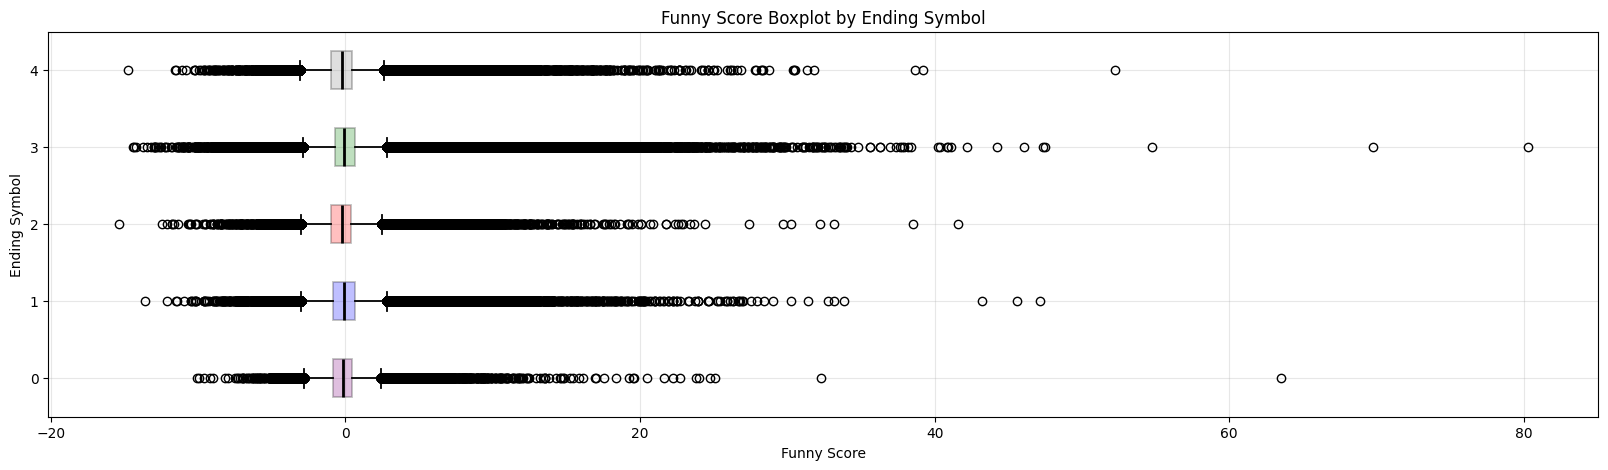

In [153]:
box_data = [dataAm[dataAm["ending"] == end]["funny_score"] for end in endings]

plt.figure(figsize=(20, 5))

bp = plt.boxplot(
    box_data,
    vert=False,
    positions=range(len(endings)),
    patch_artist=True,
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.3),
    whiskerprops=dict(linewidth=1.3),
    capprops=dict(linewidth=1.3),
)

# Match each box color to histogram colors
for patch, col in zip(bp["boxes"], colors):
    patch.set_facecolor(col)
    patch.set_alpha(0.25)

plt.yticks(range(len(endings)))


plt.xlabel("Funny Score")
plt.ylabel("Ending Symbol")
plt.title("Funny Score Boxplot by Ending Symbol")
plt.grid(alpha=0.3)


plt.show()

## Top x funniest captions!

Now lets look at top 10% of funniest captions.

In [168]:
dataAm_top = dataAm.loc[dataAm.index <= 1000]
dataAm_top

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,word_count,ending
0,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,80.26,13,.
1,Some of my patients find the loofah less threa...,2.003559,0.002514,562,0,560,2,69.78,9,.
2,My methods are Jungian. Sometimes a bar of soa...,2.003663,0.003670,273,0,272,1,63.53,17,...
3,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,54.74,3,.
4,I dreamt last night that some day judges might...,2.032787,0.022990,61,0,59,2,52.22,15,~
...,...,...,...,...,...,...,...,...,...,...
996,I think you're supposed to scatter it on the g...,1.846951,0.026019,869,332,338,199,17.16,10,.
997,THE St. Francis?,1.863817,0.025323,1006,402,339,265,17.15,3,?
998,I forgot what I came upstairs for.,1.934090,0.010499,5902,2127,2037,1738,17.15,7,.
999,"Well, we still have the mailman.",1.685101,0.020034,1537,792,437,308,17.15,6,.


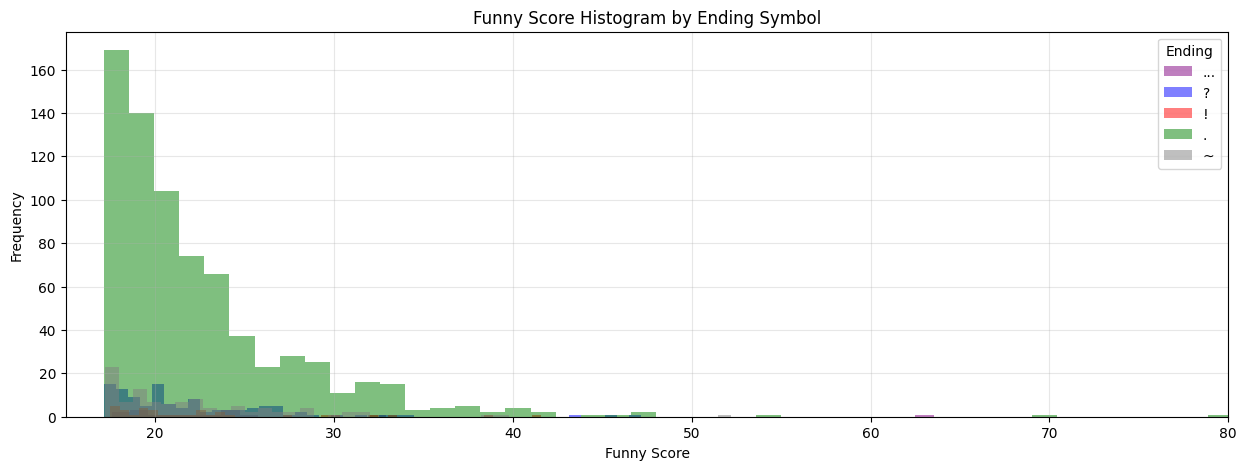

In [182]:
# Unique ending categories in fixed order
endings = ["...", "?", "!", ".", "~"]
colors = ["purple", "blue", "red", "green", "gray"]

plt.figure(figsize=(15, 5))



for end, col in zip(endings, colors):
    subset = dataAm_top[dataAm_top["ending"] == end]["funny_score"]

    plt.hist(
        subset,
        bins=45,
        alpha=0.5,
        color=col,
        label=end
    )

plt.title("Funny Score Histogram by Ending Symbol")
plt.ylabel("Frequency")
plt.xlabel("Funny Score")
plt.xlim(15, 80)
# plt.ylim(0, 65000)
plt.grid(alpha=0.3)
plt.legend(title="Ending")
plt.show()

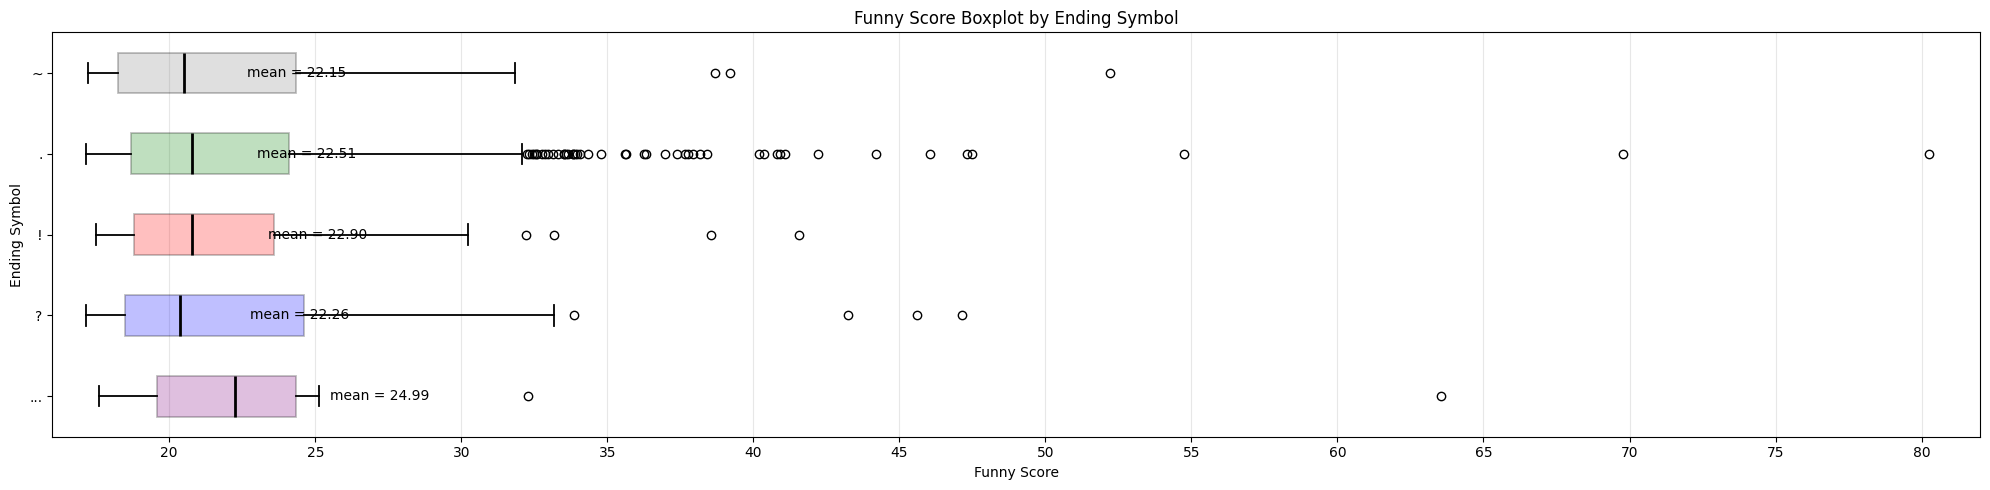

In [191]:
box_data = [dataAm_top[dataAm_top["ending"] == end]["funny_score"] for end in endings]

plt.figure(figsize=(20, 5))

bp = plt.boxplot(
    box_data,
    vert=False,
    positions=range(len(endings)),
    patch_artist=True,
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(linewidth=1.3),
    whiskerprops=dict(linewidth=1.3),
    capprops=dict(linewidth=1.3),
)


for patch, col in zip(bp["boxes"], colors):
    patch.set_facecolor(col)
    patch.set_alpha(0.25)


plt.yticks(range(len(endings)), endings)

# ----- MEAN ANNOTATION -----
for i, end in enumerate(endings):
    subset = dataAm_top[dataAm_top["ending"] == end]["funny_score"]
    mean_val = subset.mean()

    plt.text(
        mean_val + 0.5,     # little offset to the right
        i,                  # vertical pos matches box index
        f"mean = {mean_val:.2f}",
        va="center",
        fontsize=10,
        color="black"
    )

# ----- GRID STEP ADJUSTMENT -----
plt.xticks(np.arange(0, 100, 5))   # step of 5 units
plt.grid(axis="x", alpha=0.3)

# Titles
plt.title("Funny Score Boxplot by Ending Symbol")
plt.xlabel("Funny Score")
plt.ylabel("Ending Symbol")


plt.xlim(16, 82)
plt.tight_layout()
plt.show()